## CLIP COCO-Captions Tutorial

This notebook demonstrates how to finetune CLIP ViT-B/32 model on a single GPU. 

In [1]:
from fastai.vision.all import *
from fastai.distributed import *

In [2]:
from self_supervised.multimodal.clip import *
import clip
# from zero_optimizer import ZeroRedundancyOptimizer # only works with multi-gpu / distributed training

Download [COCO](https://cocodataset.org/#download) 2014 Train, Valid and Annotations

In [3]:
trainpath = Path("../../../coco/train2014/")
validpath = Path("../../../coco/val2014/")
annospath = Path("../../../coco/annotations/") 

In [4]:
train_images = get_image_files(trainpath)
valid_images = get_image_files(validpath)

In [5]:
len(train_images), len(valid_images)

(82783, 40504)

In [6]:
caption_paths = annospath.ls().filter(lambda o: 'captions' in o.name)

In [7]:
fn2captions = {}
for p in caption_paths:
    caps = json.loads(open(p).read())
    id2fn = {o['id']: o['file_name'] for o in caps['images']}
    fn2cap = {id2fn[o['image_id']]: o['caption'] for o in caps['annotations']}
    fn2captions.update(fn2cap)

assert len(fn2captions) == (len(train_images) + len(valid_images))

In [8]:
all_images = train_images[:10000] + valid_images[:5000]; len(all_images),len(fn2captions)

(15000, 123287)

In [9]:
def read_image(fn): return PILImage.create(fn)
def read_text(fn): return fn2captions[fn.name]
def dummy_targ(o): return 0 

In [10]:
clip_stats = ([0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711])
clip_tokenizer = ClipTokenizer()
size,bs = 224,128

split_func = lambda fn: True if "val2014" in str(fn) else False
dsets = Datasets(all_images, tfms=[read_image, read_text, dummy_targ], 
                 n_inp=2, 
                 splits=FuncSplitter(split_func)(all_images))
item_tfms = [RandomResizedCrop(size, min_scale=0.9), clip_tokenizer, ToTensor()]

batch_tfms = [IntToFloatTensor, Normalize.from_stats(*clip_stats)]
train_dl = TfmdDL(dsets.train, shuffle=True, bs=bs, after_item=item_tfms, after_batch=batch_tfms, drop_last=True)
valid_dl = TfmdDL(dsets.valid, shuffle=False, bs=bs*2, after_item=item_tfms, after_batch=batch_tfms)
dls = DataLoaders(train_dl, valid_dl, device=default_device())

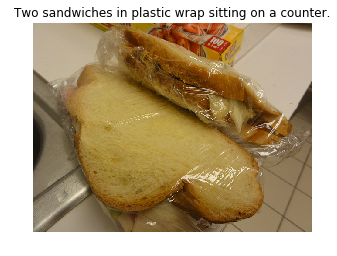

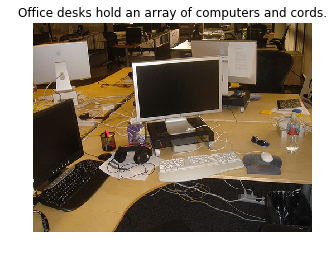

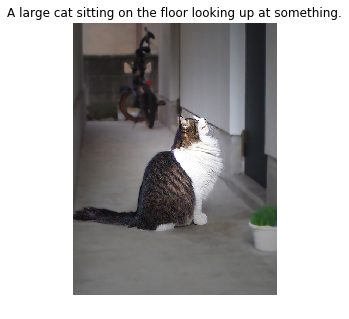

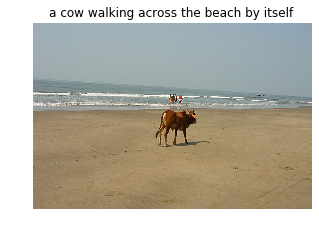

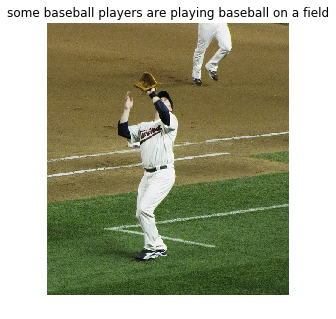

In [11]:
for i in range(5): dls.train_ds[i][0].show(title=dls.train_ds[i][1])

In [12]:
clip_trainer_cb = CLIPTrainer()
cbs = [clip_trainer_cb]
opt_func = ranger

arch = 'vitb32'
do_finetune = True
use_grad_check = True
grad_check_nchunks = 2
finetune_modelname = 'ViT-B/32'

vitb32_config_dict = vitb32_config(size, clip_tokenizer.context_length, clip_tokenizer.vocab_size)
clip_model = CLIP(**vitb32_config_dict, checkpoint=use_grad_check, checkpoint_nchunks=grad_check_nchunks)
if do_finetune:
    print("Loading pretrained model..")
    clip_pretrained_model, _ = clip.load(finetune_modelname, jit=False)
    clip_model.load_state_dict(clip_pretrained_model.state_dict())

Loading pretrained model..


In [13]:
learner = Learner(dls, clip_model, loss_func=noop, cbs=cbs, opt_func=opt_func,
              metrics=[RetrievalAtK(k=5), 
                       RetrievalAtK(k=20), 
                       RetrievalAtK(k="mean"),
                       RetrievalAtK(k="median")])
learner.to_fp16();

In [ ]:
learner.fit_flat_cos(10, 1e-5, pct_start=0.25)

epoch,train_loss,valid_loss,retrieval_at_5,retrieval_at_20,mean_retrieval_ranking,median_retrieval_ranking,time
0,0.483427,0.626659,0.696800,0.880000,10.672200,2.000000,01:09
1,0.329584,0.603628,0.704600,0.887400,9.895600,2.000000,01:09
2,0.228769,0.623878,0.711400,0.883800,9.914200,2.000000,01:08
3,0.162651,0.673036,0.696200,0.883400,10.386600,2.000000,01:10
4,0.128091,0.703642,0.698400,0.877000,10.792000,2.000000,01:10
5,0.094277,0.707506,0.696800,0.875600,10.511600,2.000000,01:08


/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
